In [1]:
%matplotlib inline

from multiprocessing.dummy import Pool

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import pandas as pd
import requests

start_year = 1000
end_year = 2020
rolling_avg_window = 5
url = 'https://query.wikidata.org/sparql'

In [2]:
import logging
import time
from functools import wraps

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def retry(exception_to_check, tries=5, delay=1, backoff=5):
    def deco_retry(func):
        @wraps(func)
        def f_retry(*args, **kwargs):
            mtries, mdelay = tries, delay
            while mtries > 1:
                logger.debug('Calling %s with args: %s', func.__name__, args)
                try:
                    return_val = func(*args, **kwargs)
                    logger.debug('Successful on try %s', tries - mtries)
                    return return_val
                except exception_to_check as error:
                    logger.debug("%s, Retrying in %d seconds...", str(error), mdelay)
                    time.sleep(mdelay)
                    mtries -= 1
                    mdelay *= backoff
            return func(*args, **kwargs)
        return f_retry
    return deco_retry


In [3]:
# Ideally, you'd push all the computation for each year into the SQL side
# Unfortunately, for anything over ~5 years I kept getting timeouts from the
# SPARQL API, so I did it iteratively one year at a time, parallelized it,
# and ran some of the compute in pandas instead.

query_template = """
SELECT ?person ?personLabel ?age_at_death ?death_date
WHERE {{
        # is a human
        ?person wdt:P31 wd:Q5.

        # get birth date, only if present to the day
        ?person p:P569/psv:P569 ?birth_date_node. hint:Prior hint:rangeSafe true.
        ?birth_date_node wikibase:timePrecision "11"^^xsd:integer .
        ?birth_date_node wikibase:timeValue ?birth_date. hint:Prior hint:rangeSafe true.

        # get death date, only if present to the day
        ?person p:P570/psv:P570 ?death_date_node. hint:Prior hint:rangeSafe true.
        ?death_date_node wikibase:timePrecision "11"^^xsd:integer .
        ?death_date_node wikibase:timeValue ?death_date. hint:Prior hint:rangeSafe true.

        # calculate the age, precisely to the day (times and timezones ignored)
        BIND( YEAR(?death_date) - YEAR(?birth_date) -
              IF(MONTH(?death_date)<MONTH(?birth_date) ||
                 (MONTH(?death_date)=MONTH(?birth_date) && DAY(?death_date)<DAY(?birth_date)),1,0) AS ?age_at_death )
        FILTER(?death_date >= "{}-01-01"^^xsd:dateTime &&
               ?death_date <  "{}-01-01"^^xsd:dateTime)
        SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
}}
""".strip()

@retry(ValueError)
def fetch(year):
    q = query_template.format(year, year+1)
    r = requests.get(url, params = {'format': 'json', 'query': q})
    if r.status_code != 200:
        raise ValueError("Failed while fetching: %s" % year)
    return r.json()

In [14]:
def binding_to_dict(binding):
    return {k: v.get('value') for k, v in binding.items()}

def get_distro(year):
    try:
        data = fetch(year)
        results = (binding_to_dict(result) for result in data['results']['bindings'])
        df = pd.DataFrame(results)
        df["age_at_death"] = pd.to_numeric(df["age_at_death"])
        distro = {'50th pct': df.age_at_death.median(),
                  '90th pct': df.age_at_death.quantile(0.9),
                  '10th pct': df.age_at_death.quantile(0.1),              
                  'year': year,
                  'count': df.shape[0]}
    except:
        return None

    if year % 10 == 0:
        logger.info('Processed %s', year)
    return distro

In [6]:
pool = Pool(10)
distros = pool.map(get_distro, range(start_year, end_year))

INFO:__main__:Processed 1000
INFO:__main__:Processed 1130
INFO:__main__:Processed 1160
INFO:__main__:Processed 1170
INFO:__main__:Processed 1240
INFO:__main__:Processed 1250
INFO:__main__:Processed 1180
INFO:__main__:Processed 1260
INFO:__main__:Processed 1270
INFO:__main__:Processed 1290
INFO:__main__:Processed 1310
INFO:__main__:Processed 1060
INFO:__main__:Processed 1100
INFO:__main__:Processed 1340
INFO:__main__:Processed 1350
INFO:__main__:Processed 1360
INFO:__main__:Processed 1370
INFO:__main__:Processed 1380
INFO:__main__:Processed 1120
INFO:__main__:Processed 1320
INFO:__main__:Processed 1030
INFO:__main__:Processed 1330
INFO:__main__:Processed 1390
INFO:__main__:Processed 1280
INFO:__main__:Processed 1220
INFO:__main__:Processed 1450
INFO:__main__:Processed 1460
INFO:__main__:Processed 1230
INFO:__main__:Processed 1470
INFO:__main__:Processed 1480
INFO:__main__:Processed 1490
INFO:__main__:Processed 1500
INFO:__main__:Processed 1420
INFO:__main__:Processed 1520
INFO:__main__:

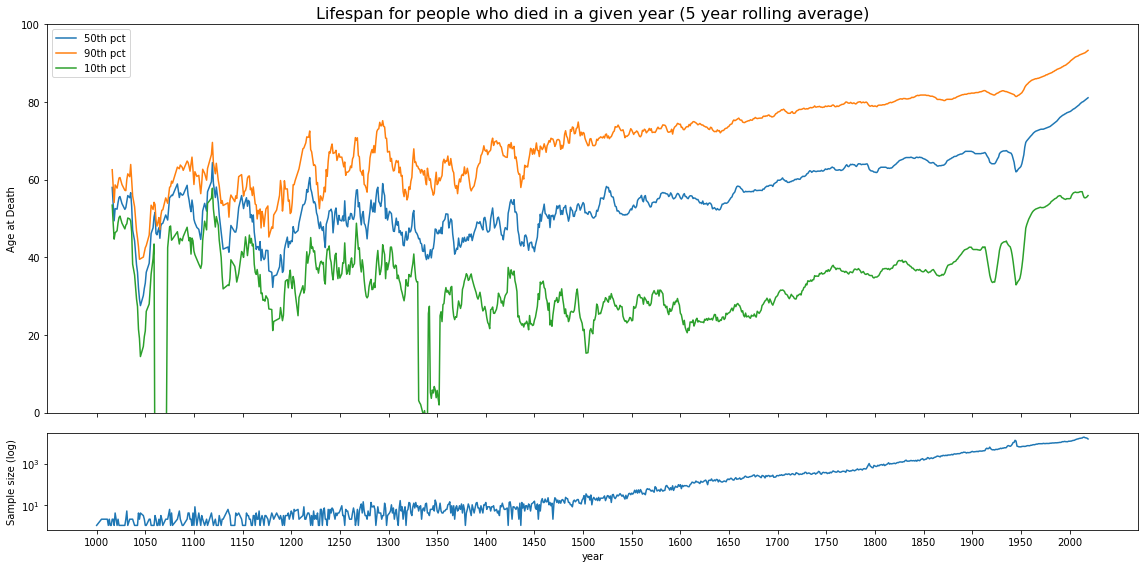

In [13]:
df = pd.DataFrame(d for d in distros if d)
df = df.set_index('year')

counts = df['count']
df = df.drop(columns=['count'])

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(16, 8), gridspec_kw={'height_ratios': [4, 1]})
counts.plot(ax=ax1, xticks=range(start_year, end_year, 50), logy=True)
ax1.set_ylabel('Sample size (log)')

df.rolling(window=10).mean()\
  .plot(ylim=(0, 100), ax=ax0)
ax0.set_ylabel('Age at Death')

ax0.set_title(f'Lifespan for people who died in a given year ({rolling_avg_window} year rolling average)', fontsize=16)
plt.tight_layout()

In [15]:
print(f'This dataset contains data on a total of {counts.sum()} people in it')

This dataset contains data on a total of 1331302 people in it
